In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from kneed import KneeLocator


In [2]:
raw=pd.read_csv('DXYArea.csv',parse_dates=['updateTime'])

In [3]:
raw.loc[0,:]

provinceName                                      北京市
provinceEnglishName                           Beijing
province_zipCode                               110000
cityName                                          朝阳区
cityEnglishName                     Chaoyang District
city_zipCode                                 110105.0
province_confirmedCount                           446
province_suspectedCount                             0
province_curedCount                               358
province_deadCount                                  8
city_confirmedCount                                72
city_suspectedCount                                 0
city_curedCount                                     0
city_deadCount                                      0
updateTime                 2020-03-16 09:39:00.850000
Name: 0, dtype: object

In [4]:

raw['year'], raw['month'], raw['day'] = list(zip(*raw['updateTime'].apply(lambda d: (d.year, d.month, d.day))))
 

temp = raw.sort_values(['provinceName', 'cityName', 'year', 'month', 'day', 'updateTime'],
                ascending=False,
                ignore_index=True).groupby(['provinceName', 'cityName', 'year', 'month', 'day']).agg({'province_confirmedCount': 'first',
                                        'province_curedCount': 'first',
                                        'province_deadCount': 'first',
                                        'city_confirmedCount': 'first',
                                        'city_curedCount': 'first',
                                        'city_deadCount': 'first'}) .reset_index(drop=False)

temp.head()


,provinceName,cityName,year,month,day,province_confirmedCount,province_curedCount,province_deadCount,city_confirmedCount,city_curedCount,city_deadCount
0,上海市,嘉定区,2020,1,27,53,3,1,1,0,0
1,上海市,嘉定区,2020,1,28,66,4,1,1,0,0
2,上海市,嘉定区,2020,1,29,96,5,1,2,0,0
3,上海市,嘉定区,2020,1,30,112,5,1,2,0,0
4,上海市,嘉定区,2020,1,31,135,9,1,2,0,0


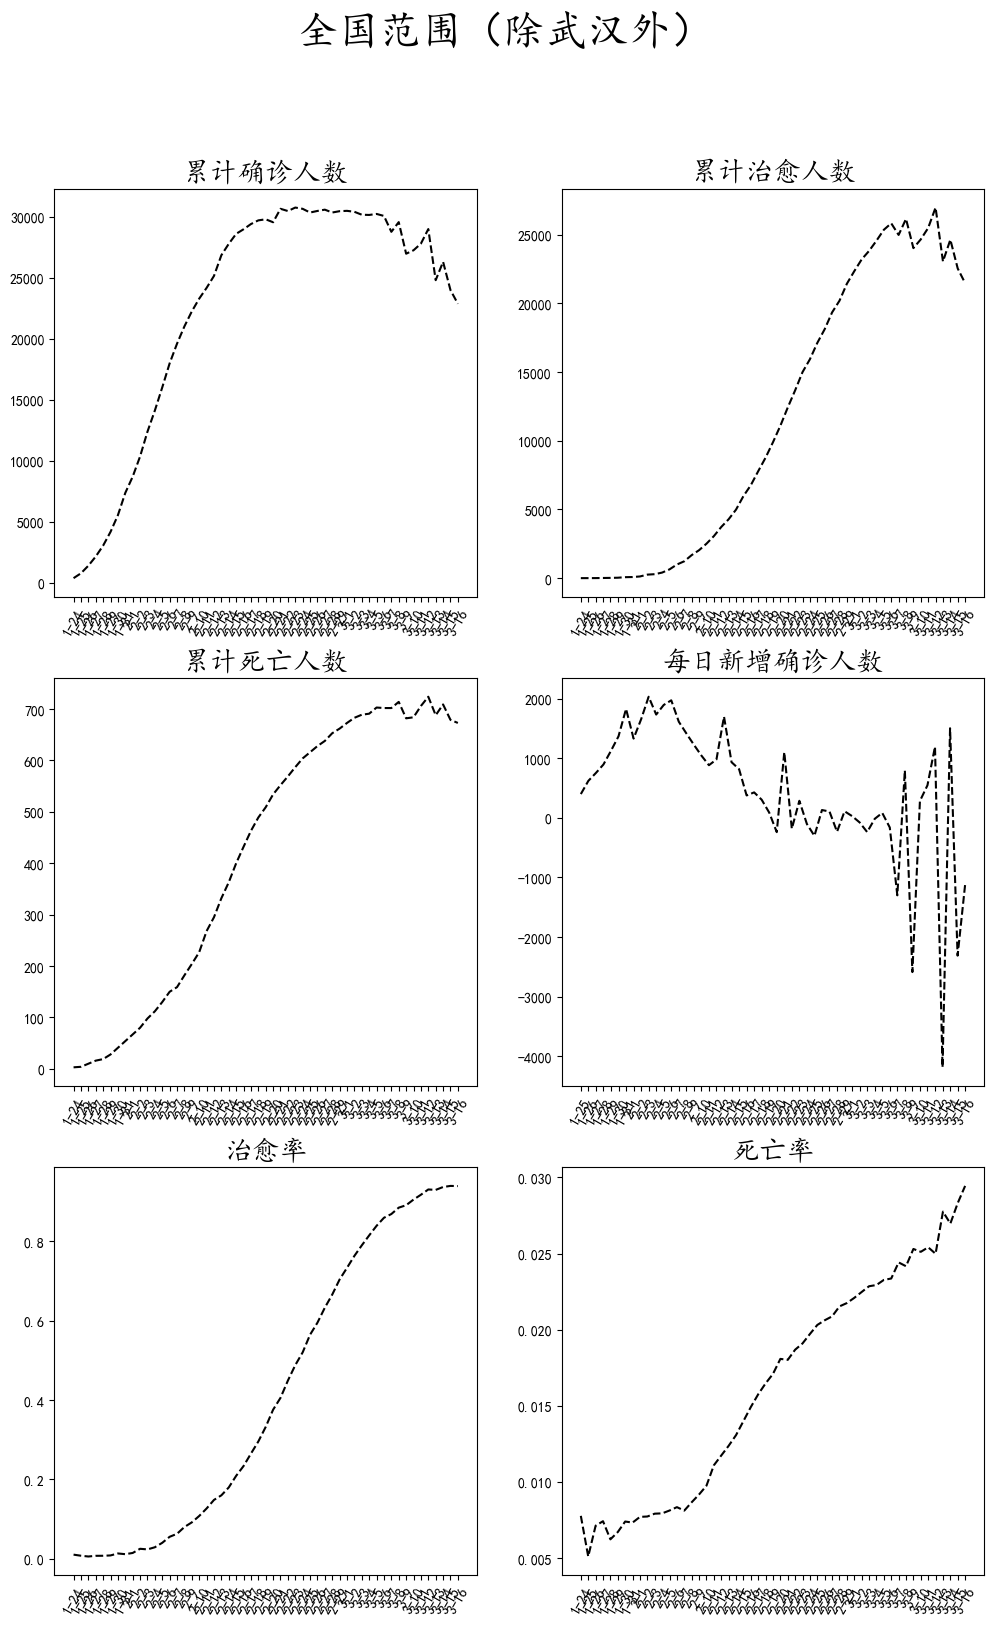

In [23]:

nationwide_confirmed_count = temp[temp['cityName'] != '武汉'].groupby(['year', 'month', 'day']) .agg({'city_confirmedCount': 'sum'}) .reset_index(drop=False)

nationwide_cured_count = temp[temp['cityName'] != '武汉'].groupby(['year', 'month', 'day']) .agg({'city_curedCount': 'sum'}) .reset_index(drop=False)

nationwide_dead_count = temp[temp['cityName'] != '武汉'].groupby(['year', 'month', 'day']) .agg({'city_deadCount': 'sum'}).reset_index(drop=False)
 

nationwide_confirmed_inc_count = nationwide_confirmed_count['city_confirmedCount'].diff()[1:]
 

nationwide_cured_ratio = nationwide_cured_count['city_curedCount'] / nationwide_confirmed_count['city_confirmedCount']
 

nationwide_died_ratio = nationwide_dead_count['city_deadCount'] / nationwide_confirmed_count['city_confirmedCount']
 

plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
 
fig, axes = plt.subplots(3, 2, figsize=[12, 18])
 
axes[0, 0].plot(nationwide_confirmed_count.index, nationwide_confirmed_count['city_confirmedCount'], 'k--')
axes[0, 0].set_title('累计确诊人数', fontsize=20)
axes[0, 0].set_xticks(nationwide_confirmed_count.index)
axes[0, 0].set_xticklabels([f"{nationwide_confirmed_count.loc[i, 'month']}-{nationwide_confirmed_count.loc[i, 'day']}"
                            for i in nationwide_confirmed_count.index], rotation=60)
 
axes[0, 1].plot(nationwide_cured_count.index, nationwide_cured_count['city_curedCount'], 'k--')
axes[0, 1].set_title('累计治愈人数', fontsize=20)
axes[0, 1].set_xticks(nationwide_cured_count.index)
axes[0, 1].set_xticklabels([f"{nationwide_cured_count.loc[i, 'month']}-{nationwide_cured_count.loc[i, 'day']}"
                            for i in nationwide_cured_count.index], rotation=60)
 
axes[1, 0].plot(nationwide_dead_count.index, nationwide_dead_count['city_deadCount'], 'k--')
axes[1, 0].set_title('累计死亡人数', fontsize=20)
axes[1, 0].set_xticks(nationwide_dead_count.index)
axes[1, 0].set_xticklabels([f"{nationwide_dead_count.loc[i, 'month']}-{nationwide_dead_count.loc[i, 'day']}"
                            for i in nationwide_dead_count.index], rotation=60)
 
axes[1, 1].plot(nationwide_confirmed_inc_count.index, nationwide_confirmed_inc_count, 'k--')
axes[1, 1].set_title('每日新增确诊人数', fontsize=20)
axes[1, 1].set_xticks(nationwide_confirmed_inc_count.index)
axes[1, 1].set_xticklabels([f"{nationwide_confirmed_count.loc[i, 'month']}-{nationwide_confirmed_count.loc[i, 'day']}"
                            for i in nationwide_confirmed_inc_count.index], rotation=60)
 
axes[2, 0].plot(nationwide_cured_ratio.index, nationwide_cured_ratio, 'k--')
axes[2, 0].set_title('治愈率', fontsize=20)
axes[2, 0].set_xticks(nationwide_cured_ratio.index)
axes[2, 0].set_xticklabels([f"{nationwide_cured_count.loc[i, 'month']}-{nationwide_cured_count.loc[i, 'day']}"
                            for i in nationwide_cured_ratio.index], rotation=60)
 
axes[2, 1].plot(nationwide_died_ratio.index, nationwide_died_ratio, 'k--')
axes[2, 1].set_title('死亡率', fontsize=20)
axes[2, 1].set_xticks(nationwide_died_ratio.index)
axes[2, 1].set_xticklabels([f"{nationwide_dead_count.loc[i, 'month']}-{nationwide_dead_count.loc[i, 'day']}"
                            for i in nationwide_died_ratio.index], rotation=60)
 
fig.suptitle('全国范围（除武汉外）', fontsize=30)
 
# 导出图像
plt.savefig('图7.png', dpi=300)

In [8]:
def knee_point_search(x, y):
    #定义keelocator模型
    
    x, y = x.tolist(), y.tolist()
    output_knees = []
    for curve in ['convex', 'concave']:
        for direction in ['increasing', 'decreasing']:
            model = KneeLocator(x=x, y=y, curve=curve, direction=direction, online=False)
            if model.knee != x[0] and model.knee != x[-1]:
                output_knees.append((model.knee, model.knee_y, curve, direction))
    
    if output_knees.__len__() != 0:
        print('发现拐点！')
        return output_knees
    else:
        print('未发现拐点！')

发现拐点！


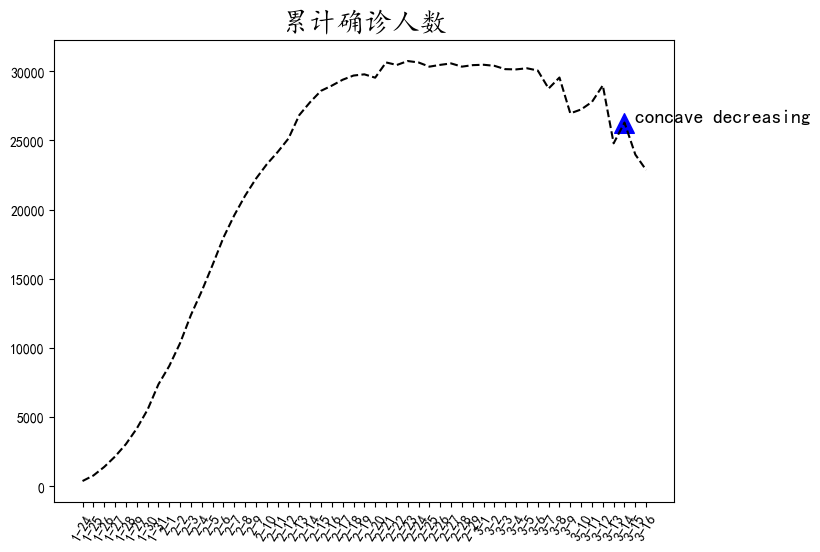

In [20]:
knee_info = knee_point_search(x=nationwide_confirmed_count.index,
                  y=nationwide_confirmed_count['city_confirmedCount'])
fig, axe = plt.subplots(figsize=[8, 6])
axe.plot(nationwide_confirmed_count.index, nationwide_confirmed_count['city_confirmedCount'], 'k--')
axe.set_title('累计确诊人数', fontsize=20)
axe.set_xticks(nationwide_confirmed_count.index)
axe.set_xticklabels([f"{nationwide_confirmed_count.loc[i, 'month']}-{nationwide_confirmed_count.loc[i, 'day']}"
                            for i in nationwide_confirmed_count.index], rotation=60)
 
for point in knee_info:
    axe.scatter(x=point[0], y=point[1], c='b', s=200, marker='^')
    axe.annotate(text=f'{point[2]} {point[3]}', xy=(point[0]+1, point[1]), fontsize=14)
 
# 导出图像
plt.savefig('图1.png', dpi=300)

发现拐点！


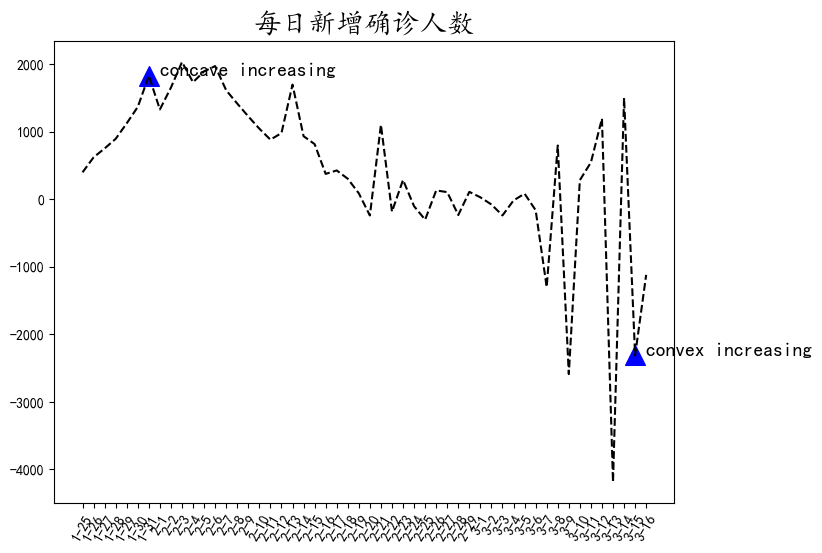

In [37]:
knee_info=knee_point_search(x=nationwide_confirmed_inc_count.index,
y=nationwide_confirmed_inc_count)
fig, axe = plt.subplots(figsize=[8, 6])
axe.plot(nationwide_confirmed_inc_count.index,nationwide_confirmed_inc_count, 'k--')
axe.set_title('每日新增确诊人数', fontsize=20)
axe.set_xticks(nationwide_confirmed_inc_count.index)
axe.set_xticklabels([f"{nationwide_confirmed_count.loc[i, 'month']}-{nationwide_confirmed_count.loc[i, 'day']}"
                            for i in nationwide_confirmed_inc_count.index], rotation=60)
 
for point in knee_info:
    axe.scatter(x=point[0], y=point[1], c='b', s=200, marker='^')
    axe.annotate(text=f'{point[2]} {point[3]}', xy=(point[0]+1, point[1]), fontsize=14)
 
# 导出图像
plt.savefig('图2.png', dpi=300)


未发现拐点！
None


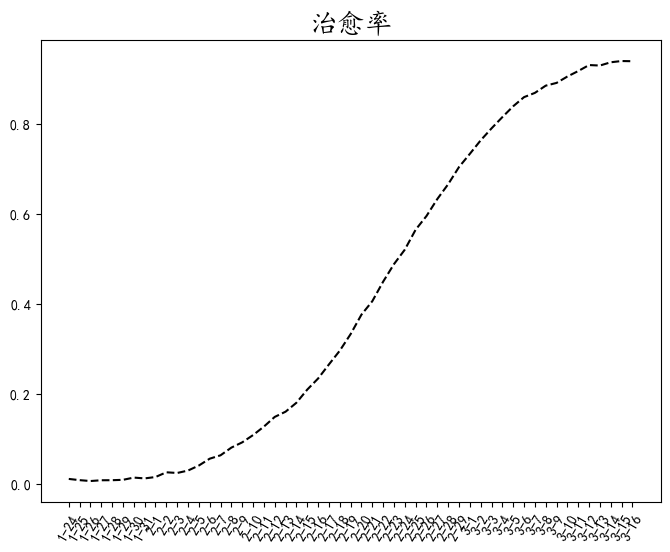

In [38]:
knee_info=knee_point_search(x=nationwide_cured_ratio.index,
y=nationwide_cured_ratio)
fig, axe = plt.subplots(figsize=[8, 6])
axe.plot(nationwide_cured_ratio.index, nationwide_cured_ratio, 'k--')
axe.set_title('治愈率', fontsize=20)
axe.set_xticks(nationwide_cured_ratio.index)
axe.set_xticklabels([f"{nationwide_cured_count.loc[i, 'month']}-{nationwide_cured_count.loc[i, 'day']}"
                            for i in nationwide_cured_count.index], rotation=60)
print(knee_info)



发现拐点！


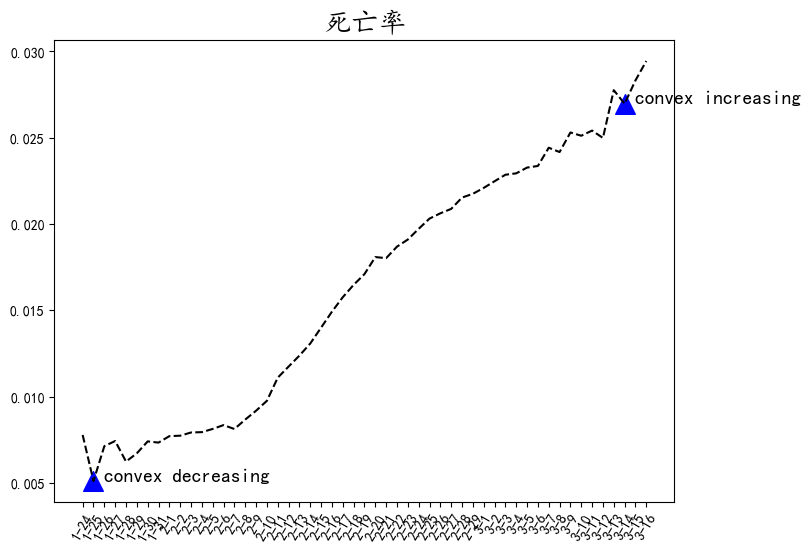

In [41]:
knee_info=knee_point_search(x=nationwide_died_ratio.index,
y=nationwide_died_ratio)
fig, axe = plt.subplots(figsize=[8, 6])
axe.plot(nationwide_died_ratio.index,nationwide_died_ratio, 'k--')
axe.set_title('死亡率', fontsize=20)
axe.set_xticks(nationwide_died_ratio.index)
axe.set_xticklabels([f"{nationwide_dead_count.loc[i, 'month']}-{nationwide_dead_count.loc[i, 'day']}"
                            for i in nationwide_dead_count.index], rotation=60)
 
for point in knee_info:
    axe.scatter(x=point[0], y=point[1], c='b', s=200, marker='^')
    axe.annotate(text=f'{point[2]} {point[3]}', xy=(point[0]+1, point[1]), fontsize=14)
 
# 导出图像
plt.savefig('图11.png', dpi=300)

In [201]:
from scipy.ndimage import gaussian_filter


#使用高斯滤波器平滑数据，进行拐点检测

def main(xs,ys):
    

    # smooth out noise
    smoothed = gaussian_filter(ys, 2.)

    # find the point where the signal goes above the background noise
    # level (assumed to be zero here).
    base = 0.01
    std = (ys[xs < 3] - base).std()
    m = ys< (base -3. * std)
    x0 = xs[m]
    y0 = ys[m]
    plt.plot(xs, ys)
    #plt.plot(xs, smoothed, '-')
    plt.plot(x0, y0, 'o')
    plt.show()

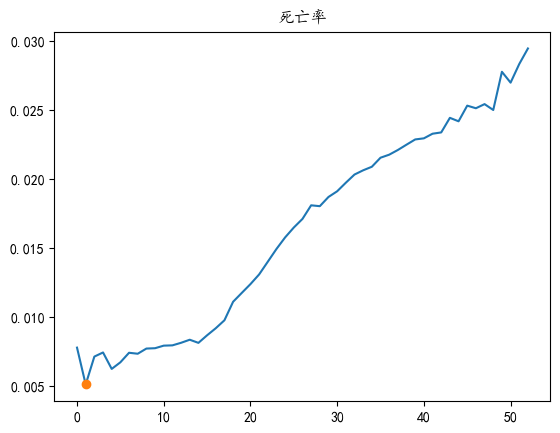

In [202]:
plt.title('死亡率')
main(nationwide_died_ratio.index,nationwide_died_ratio)


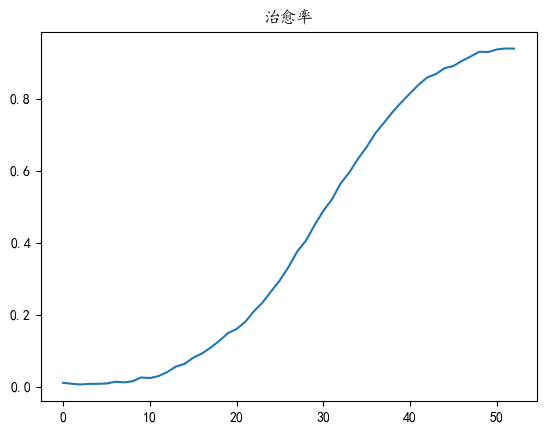

In [203]:
plt.title('治愈率')
main(nationwide_cured_ratio.index,nationwide_cured_ratio)

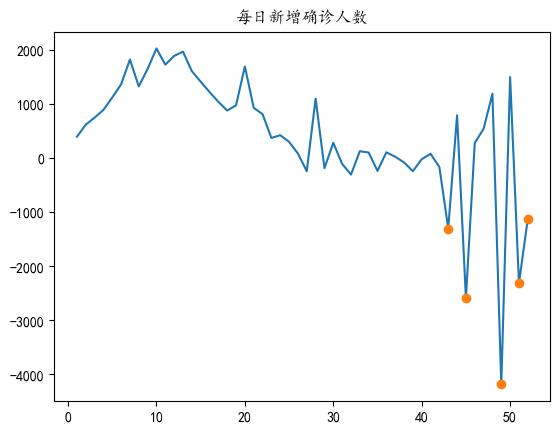

In [204]:
plt.title('每日新增确诊人数')
main(nationwide_confirmed_inc_count.index,nationwide_confirmed_inc_count)

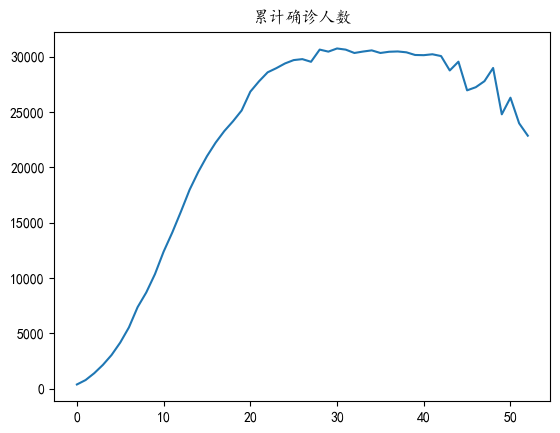

In [206]:
plt.title('累计确诊人数')
main(nationwide_confirmed_count.index, nationwide_confirmed_count['city_confirmedCount'])

In [89]:
from scipy.signal import savgol_filter
#使用Savitzky-Golay滤波器滤波器平滑数据，进行拐点检测
def val_eb(x,y,gap):
    col=[]
    y_col = []
    for i in range(gap, len(y) - gap):
        col.append(np.var(y[i - gap:i]) / np.var(y[i:i + gap]))
    y_col.append(i)
    return col,y_col

In [113]:
def pl(x,y):
    y = savgol_filter(y, 5, 3)
    v,y_v = val_eb(x,y,1)
    i = y_v[v.index(max(v))]
    print(x[i],y[i],x[i+1],y[i+1],x[i-1],y[i-1])
    plt.plot(x,y,color="green")
    plt.scatter(x[i],y[i])
    plt.show()

51 0.02785851307112104 52 0.029559007137297002 50 0.027658867736735513


C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_15388\740353766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  col.append(np.var(y[i - gap:i]) / np.var(y[i:i + gap]))


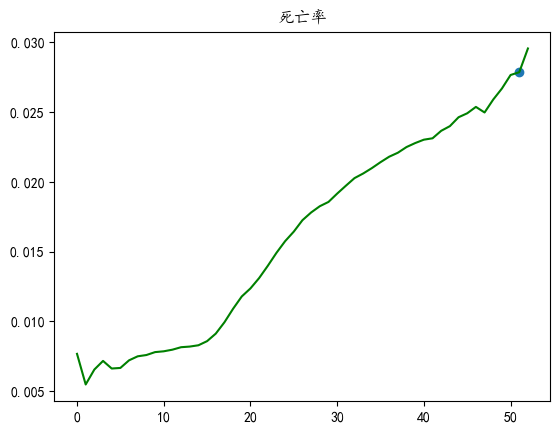

In [207]:
plt.title('死亡率')
pl(nationwide_died_ratio.index,nationwide_died_ratio)


51 0.9402498724057758 52 0.9388101420284652 50 0.9354560737922197


C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_15388\740353766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  col.append(np.var(y[i - gap:i]) / np.var(y[i:i + gap]))


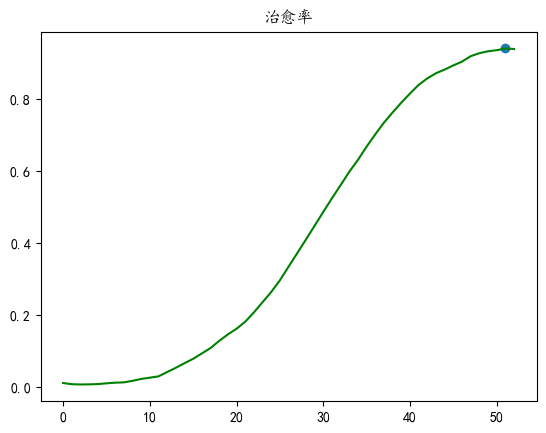

In [208]:
plt.title('治愈率')
pl(nationwide_cured_ratio.index,nationwide_cured_ratio)

51 -308.0857142857076 52 -1621.2285714285454 50 -1505.3714285714286


C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_15388\740353766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  col.append(np.var(y[i - gap:i]) / np.var(y[i:i + gap]))


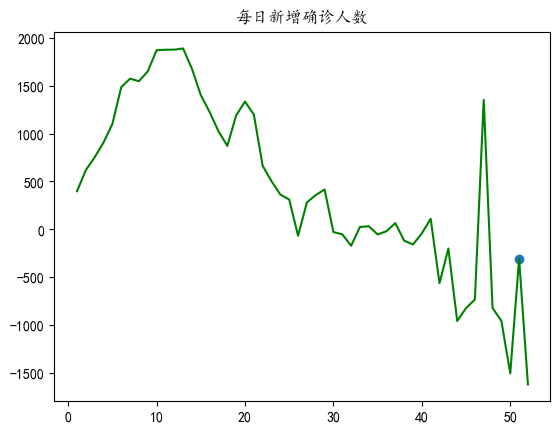

In [210]:
plt.title('每日新增确诊人数')
pl(nationwide_confirmed_inc_count.index,nationwide_confirmed_inc_count)

51 24806.25714285714 52 22649.685714285715 50 25046.114285714284


C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_15388\740353766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  col.append(np.var(y[i - gap:i]) / np.var(y[i:i + gap]))


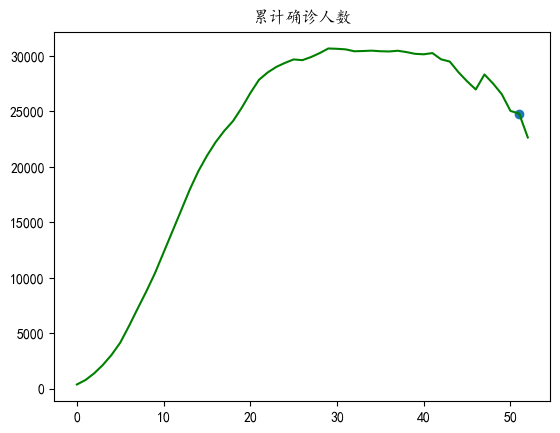

In [212]:
plt.title('累计确诊人数')
pl(nationwide_confirmed_count.index, nationwide_confirmed_count['city_confirmedCount'])